In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle as pkl
import gc
import os
from scipy.linalg import svdvals

from src.simulation import sim_glm_pop
from src.theory import y_pred_full, covariance_full,  y_0_quad,  find_iso_rate, y_corrected_quad, find_iso_rate_input, cor_pred, loop_correction
from src.correlation_functions import rate, two_pop_correlation, mean_pop_correlation, sum_by_region
from src.plotting import raster_plot, abline
from src.generate_connectivity import excitatory_only, gen_adjacency, hippo_weights, macro_weights

baseline: 0.15318540627551352


/Users/cul434/Documents/Academic/Research/meanfieldtheorymemory/src/theory.py:89: ComplexWarning: Casting complex values to real discards the imaginary part
  EE[m, l] = 1/(2 - E[m] - E[l])


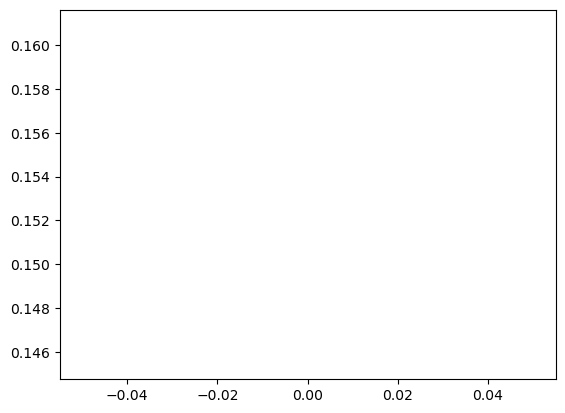

from loop 0
[0.4 0.4 0.5 0.4 0.4 0.5]


100%|██████████| 49999/49999 [00:04<00:00, 10096.43it/s]


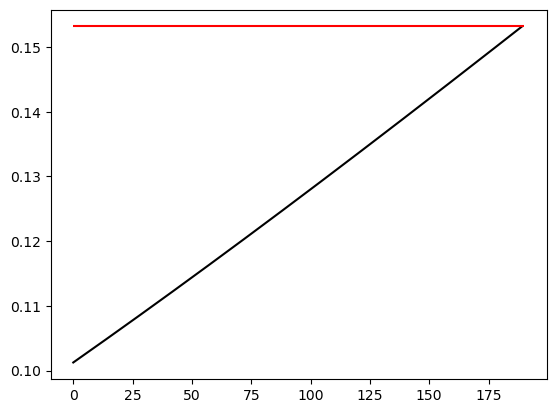

from loop 190
[0.4950951  0.4950951  0.54754755 0.4950951  0.4950951  0.54754755]


100%|██████████| 49999/49999 [00:05<00:00, 9852.24it/s] 


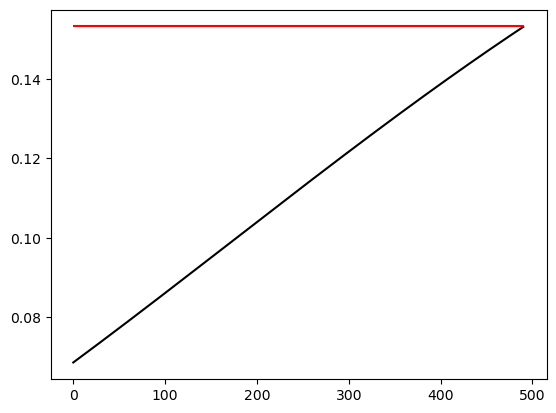

from loop 491
[0.64574575 0.64574575 0.62287287 0.64574575 0.64574575 0.62287287]


100%|██████████| 49999/49999 [00:04<00:00, 10094.48it/s]


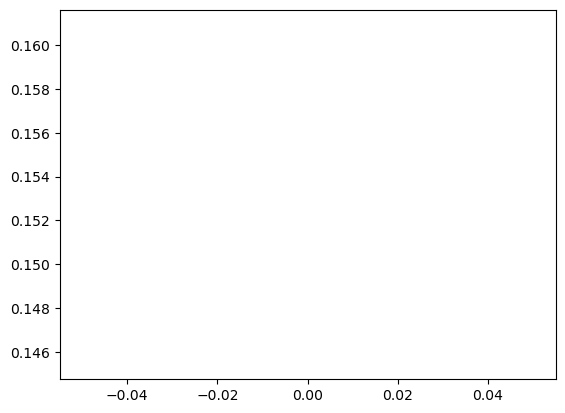

from loop 0
[0.4 0.4 0.5 0.4 0.4 0.5]


100%|██████████| 49999/49999 [00:05<00:00, 9698.11it/s] 


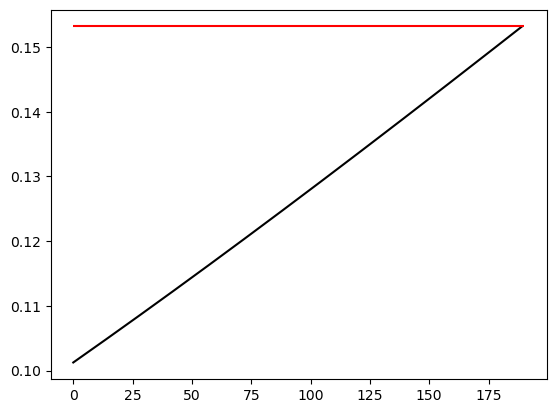

from loop 190
[0.4950951  0.4950951  0.54754755 0.4950951  0.4950951  0.54754755]


100%|██████████| 49999/49999 [00:04<00:00, 10442.22it/s]


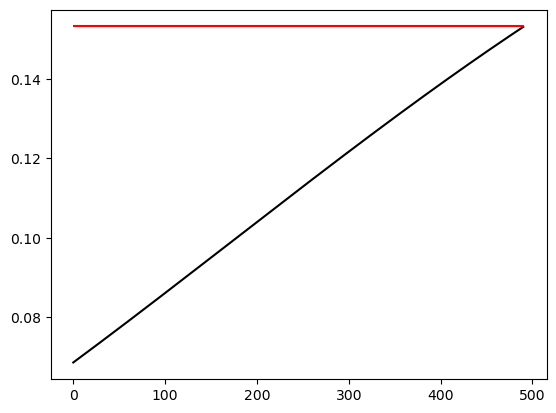

from loop 491
[0.64574575 0.64574575 0.62287287 0.64574575 0.64574575 0.62287287]


100%|██████████| 49999/49999 [00:05<00:00, 8726.29it/s] 


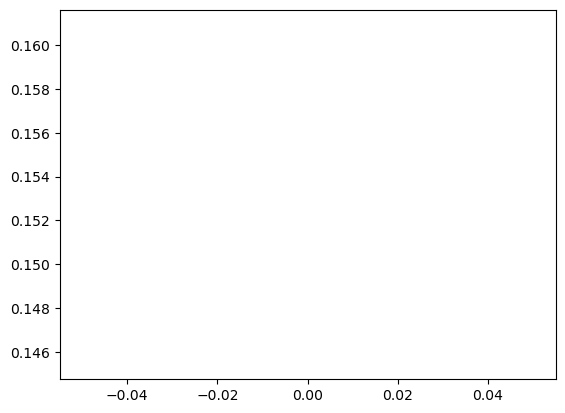

from loop 0
[0.4 0.4 0.5 0.4 0.4 0.5]


100%|██████████| 49999/49999 [00:05<00:00, 8883.11it/s] 


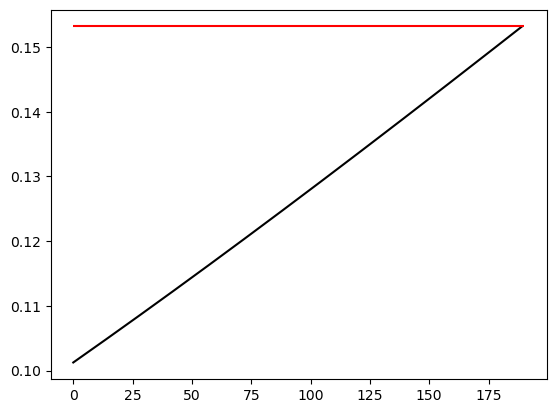

from loop 190
[0.4950951  0.4950951  0.54754755 0.4950951  0.4950951  0.54754755]


100%|██████████| 49999/49999 [00:05<00:00, 9027.18it/s] 


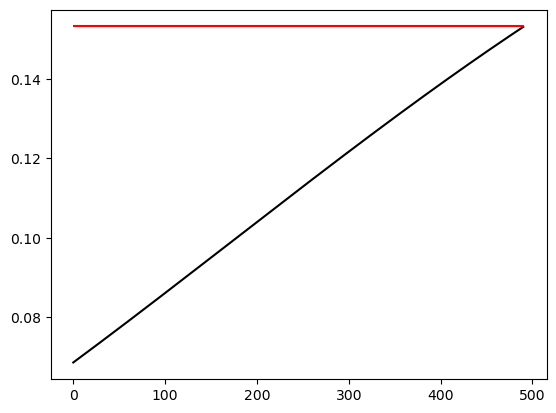

from loop 491
[0.64574575 0.64574575 0.62287287 0.64574575 0.64574575 0.62287287]


100%|██████████| 49999/49999 [00:04<00:00, 10432.26it/s]


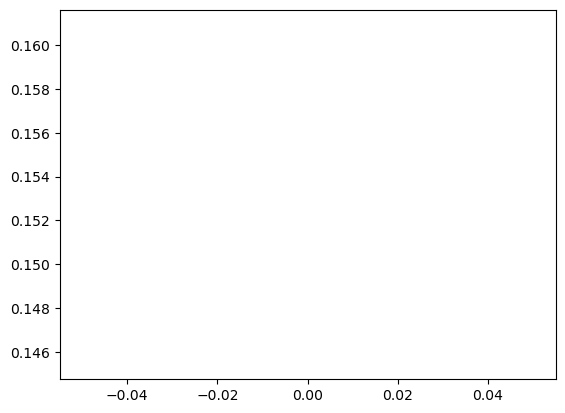

from loop 0
[0.4 0.4 0.5 0.4 0.4 0.5]


100%|██████████| 49999/49999 [00:04<00:00, 10155.62it/s]


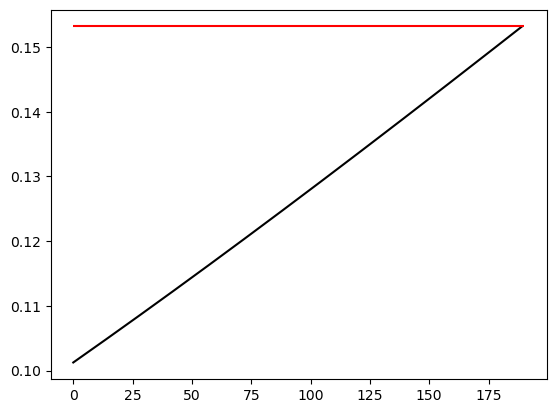

from loop 190
[0.4950951  0.4950951  0.54754755 0.4950951  0.4950951  0.54754755]


100%|██████████| 49999/49999 [00:04<00:00, 10312.79it/s]


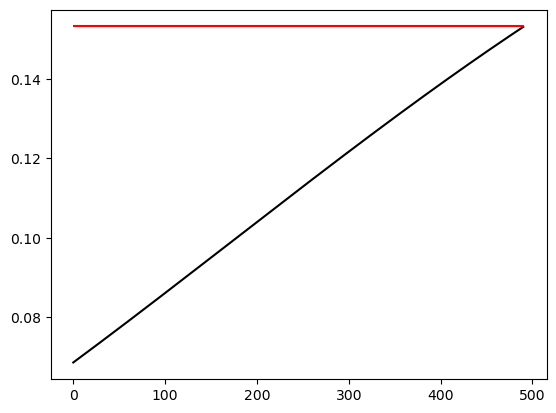

from loop 491
[0.64574575 0.64574575 0.62287287 0.64574575 0.64574575 0.62287287]


100%|██████████| 49999/49999 [00:05<00:00, 8528.65it/s] 


         pred_rate_engram  pred_rate_non_engram  tree_rate_engram  \
g   h                                                               
1.0 1.0          0.153412              0.152549          0.153185   
    1.5          0.171350              0.153881          0.170148   
    2.0          0.197492              0.155686          0.193216   
2.0 1.0          0.153453              0.152953          0.153062   
    1.5          0.171780              0.152197          0.170363   
    2.0          0.198141              0.151093          0.193894   
3.0 1.0          0.153240              0.154444          0.153734   
    1.5          0.172767              0.150401          0.172106   
    2.0          0.201104              0.144703          0.197238   

         sim_rate_engram  sim_rate_non_engram  pred_cor_engram_vs_engram  \
g   h                                                                      
1.0 1.0         0.155192             0.154000                   0.002116   
    1.5     

In [2]:
# generate adjacency matrix 
N_E = 60
N_I = 15
cells_per_region =np.array([N_E, N_E, N_I,  N_E, N_E, N_I])
N = np.sum(cells_per_region)
pEE = .2
pIE = .8
pII = .8
pEI = .8

macro_connectivity = np.array([
             [pEE, pEE, pEI, pEE, pEE, pEI],
             [pEE, pEE, pEI, pEE, pEE, pEI],
             [pIE, pIE, pII, pIE, pIE, pII],
             [pEE, pEE, pEI, pEE, pEE, pEI],
             [pEE, pEE, pEI, pEE, pEE, pEI],
             [pIE, pIE, pII, pIE, pIE, pII]])
             
A, index_dict = gen_adjacency(cells_per_region, macro_connectivity)


#simulation parameters 
dt = 0.02
tstop = 1000

b_small = np.array([.4, .4, .5, .4, .4, .5])  #without excitability
J0 = .2
g_ii = 1
g_min = 1
g_max = 3
n_g = 3
h_h = 2
gs = np.linspace(g_min, g_max, n_g)
trials = 4
J =  hippo_weights(index_dict, A, h3 = 1, h1 = 1, g = 1, J = J0,  g_ii =  g_ii)
J_baseline = sum_by_region(J, index_dict=index_dict)


y_baseline = y_0_quad(J_baseline, b_small)

print("baseline: {}".format(y_baseline[3]))
ys_tree_engram = []
ys_tree_non_engram = []
ys_pred_engram = []
ys_sim_engram = []
ys_pred_non_engram = []
ys_sim_non_engram = []
h_list = []
g_list = []
cors_ee = []
cors_en = []
cors_nn = []
sim_cors_ee = []
sim_cors_en = []
sim_cors_nn = []

for i in range(trials):
    for g in gs:
        J =  hippo_weights(index_dict, A, h3 = 1, h1 = 1, g = g, J = J0,  g_ii =  g_ii)
        J_small = sum_by_region(J, index_dict=index_dict)
        b_iso =find_iso_rate_input(target_rate= y_baseline[3], J = J_small, b = b_small, b0_min = 0, b0_max = .5, n_points=1000)
        print(b_iso)
        for h in [1,1.5, 2]:
            h_list.append(h)
            g_list.append(g)

            J =  hippo_weights(index_dict, A, h3 = h, h1 = h, g = g, J = J0,  g_ii =  g_ii)
            J_small = sum_by_region(J, index_dict=index_dict)

            y_q_red = y_0_quad(J_small, b_iso, steps = 2000)
            ys_tree_engram.append(y_q_red[3])
            ys_tree_non_engram.append(y_q_red[4])
            correction = np.real(loop_correction(J_small,  y_q_red, b_iso))
            y_corrected = y_q_red + correction 
            ys_pred_engram.append(y_corrected[3])
            ys_pred_non_engram.append(y_corrected[4])

            J_lin =J_small* (2*(J_small@y_corrected + b_iso))[...,None]
            pred_cors_mat = cor_pred(J_lin, cells_per_region, y_corrected)
            cors_ee.append(pred_cors_mat[3,3])
            cors_en.append(pred_cors_mat[3,4])
            cors_nn.append(pred_cors_mat[4,4])

            
            b = np.concatenate([b_iso[i]*np.ones(cells_per_region[i]) for i in range(6)])
            v, spktimes = sim_glm_pop(J=J,  E=b, dt = dt, tstop=tstop,  v_th = 0, maxspikes = tstop * N, p = 2)

            engram_cells = index_dict["CA1E"]
            non_engram_cells = index_dict["CA1P"]


            mean_rate = np.mean([rate(spktimes, i, dt, tstop) for i in engram_cells])
            ys_sim_engram.append(mean_rate)


            mean_rate = np.mean([rate(spktimes, i, dt, tstop) for i in non_engram_cells])
            ys_sim_non_engram.append(mean_rate)


            sim_cors_ee.append(0)
            sim_cors_en.append(0)
            sim_cors_nn.append(0)
            # sim_cors_ee.append(mean_pop_correlation(spktimes, engram_cells, dt, tstop))
            # sim_cors_en.append(two_pop_correlation(spktimes, engram_cells, non_engram_cells, dt, tstop))
            # sim_cors_nn.append(mean_pop_correlation(spktimes, non_engram_cells, dt, tstop))


df = pd.DataFrame({"g" : g_list, "h" : h_list, "pred_rate_engram" : ys_pred_engram, "pred_rate_non_engram" : ys_pred_non_engram,  
                                            "tree_rate_engram" : ys_tree_engram, "pred_rate_non_engram" : ys_tree_non_engram,  
                                            "sim_rate_engram" : ys_sim_engram, "sim_rate_non_engram" : ys_sim_non_engram, 
                                            "pred_cor_engram_vs_engram": cors_ee,  "pred_cor_non_engram_vs_non_engram": cors_nn,"pred_cor_engram_vs_non_engram": cors_en, 
                                            "sim_cor_engram_vs_engram": sim_cors_ee,  "sim_cor_non_engram_vs_non_engram": sim_cors_nn,"sim_cor_engram_vs_non_engram": sim_cors_en})

df = df.groupby(["g", "h"]).mean()
print(df)
df = df.reset_index()
print(df.columns)

# Pivot the DataFrame
pivoted_df = df.pivot(index='g', columns='h', values=["pred_rate_engram", "pred_rate_non_engram", "sim_rate_engram" , "sim_rate_non_engram", 
"pred_cor_engram_vs_engram",  "pred_cor_non_engram_vs_non_engram" , "pred_cor_engram_vs_non_engram", 
"sim_cor_engram_vs_engram",  "sim_cor_non_engram_vs_non_engram" , "sim_cor_engram_vs_non_engram"])

# Flatten the multi-level columns
pivoted_df.columns = [f'{col[0]}_h={col[1]}' for col in pivoted_df.columns]

# Reset the index
pivoted_df= pivoted_df.reset_index()

/Users/cul434/Documents/Academic/Research/meanfieldtheorymemory/src/plotting.py:15: UserWarning: 
The palette list has fewer values (1) than needed (270) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data = df, x = "time", y = "neuron", marker = "|" , s = s/(.5*len(neurons)), ax = ax, hue = "neuron",  palette = ["black"])


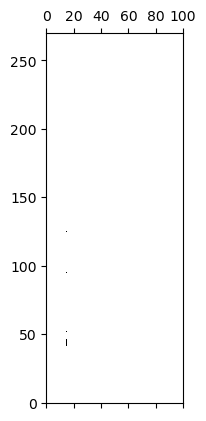

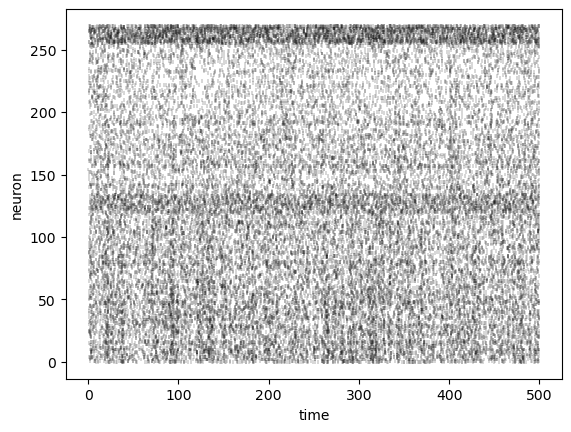

In [3]:
plt.spy(v.T < 0, extent = (0, tstop/10, 0, N))
raster_plot(spktimes=spktimes, neurons = range(N), t_start = 0, t_stop = 500)

/Users/cul434/miniconda3/envs/meanfieldtheorymemory/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/cul434/miniconda3/envs/meanfieldtheorymemory/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/cul434/miniconda3/envs/meanfieldtheorymemory/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/cul434/miniconda3/envs/meanfieldtheorymemory/lib/python3.10/site-packages/seaborn

<AxesSubplot: xlabel='h', ylabel='pred_rate_engram'>

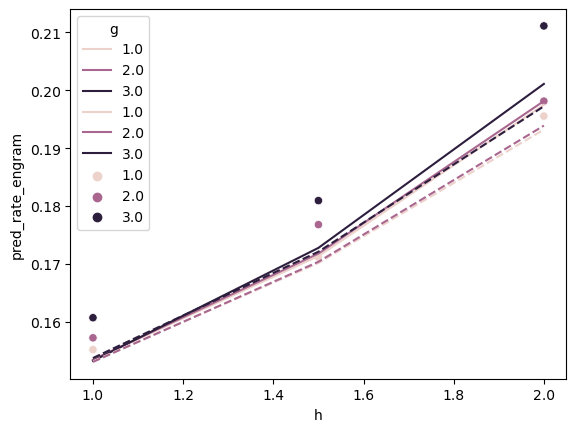

In [4]:
sns.lineplot(df, y ="pred_rate_engram", x = "h", hue = "g" )
sns.lineplot(df, y ="tree_rate_engram", x = "h", hue = "g", linestyle = "--" )
sns.scatterplot(df, y ="sim_rate_engram", x = "h", hue = "g" )

In [6]:
b_iso

array([0.64574575, 0.64574575, 0.62287287, 0.64574575, 0.64574575,
       0.62287287])

/Users/cul434/miniconda3/envs/meanfieldtheorymemory/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/cul434/miniconda3/envs/meanfieldtheorymemory/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<AxesSubplot: xlabel='h', ylabel='pred_cor_engram_vs_engram'>

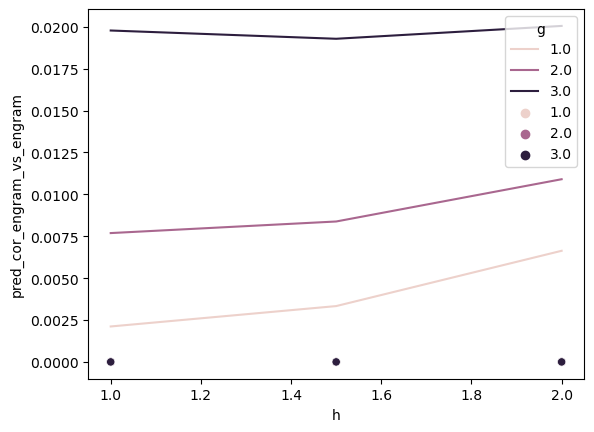

In [5]:
sns.lineplot(df, y ="pred_cor_engram_vs_engram", x = "h", hue = "g" )
sns.scatterplot(df, y ="sim_cor_engram_vs_engram", x = "h", hue = "g" )